## Dependencies

In [76]:
# ! pip install -r requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm
import itertools
import scipy.stats as stats

## Dataset

In [49]:
mkt_data = pd.read_csv('data/mkt_data.csv')
mkt_data.head(10)

,id,send_date,estimated_age,age_range,channel,coupon,clicked,last_step,nb_units,order_value
0,1,2019-04-12,59,46-60,SMS,2,0,received,0,0
1,2,2019-04-08,27,18-30,Email,2,0,received,0,0
2,3,2019-04-05,74,60+,Email,2,0,received,0,0
3,4,2019-04-21,32,31-45,SMS,2,0,received,0,0
4,5,2019-04-28,42,31-45,Email,2,0,received,0,0
5,6,2019-04-02,25,18-30,Email,4,0,received,0,0
6,7,2019-04-06,26,18-30,Email,2,0,received,0,0
7,8,2019-04-03,47,46-60,Email,6,0,received,0,0
8,9,2019-04-05,38,31-45,Email,6,0,received,0,0
9,10,2019-04-14,20,18-30,SMS,6,0,received,0,0


In [50]:
mkt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             300000 non-null  int64 
 1   send_date      300000 non-null  object
 2   estimated_age  300000 non-null  int64 
 3   age_range      300000 non-null  object
 4   channel        300000 non-null  object
 5   coupon         300000 non-null  int64 
 6   clicked        300000 non-null  int64 
 7   last_step      300000 non-null  object
 8   nb_units       300000 non-null  int64 
 9   order_value    300000 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.9+ MB


In [51]:
mkt_data.columns

Index(['id', 'send_date', 'estimated_age', 'age_range', 'channel', 'coupon',
       'clicked', 'last_step', 'nb_units', 'order_value'],
      dtype='object')

## Summary Statistics and fit distribution

In [52]:
mkt_data[['send_date', 'estimated_age', 'age_range', 'channel', 'coupon',
       'clicked', 'last_step', 'nb_units', 'order_value']].describe(include='all')

,send_date,estimated_age,age_range,channel,coupon,clicked,last_step,nb_units,order_value
count,300000,300000.000000,300000,300000,300000.00000,300000.000000,300000,300000.000000,300000.000000
unique,31,NaN,4,2,NaN,NaN,6,NaN,NaN
top,2019-04-22,NaN,31-45,SMS,NaN,NaN,received,NaN,NaN
freq,9889,NaN,122900,163511,NaN,NaN,282234,NaN,NaN
mean,NaN,38.145600,NaN,NaN,3.09778,0.059220,NaN,0.010450,0.386213
std,NaN,13.855912,NaN,NaN,1.47778,0.236036,NaN,0.263529,10.305920
min,NaN,18.000000,NaN,NaN,2.00000,0.000000,NaN,0.000000,0.000000
25%,NaN,27.000000,NaN,NaN,2.00000,0.000000,NaN,0.000000,0.000000
50%,NaN,36.000000,NaN,NaN,2.00000,0.000000,NaN,0.000000,0.000000
75%,NaN,45.000000,NaN,NaN,4.00000,0.000000,NaN,0.000000,0.000000


In [80]:
analytic_df = mkt_data[['send_date', 'estimated_age', 'age_range', 'channel', 'coupon',
 'last_step', 'nb_units', 'order_value']]

age_mapping = {'18-30': 1, '31-45': 2, '46-60': 3, '60+': 4}
analytic_df['age_range_numeric'] = analytic_df['age_range'].map(age_mapping)

event_mapping = {
    'received': 1, 
    'bounced': 2, 
    'saw review': 3, 
    'added to cart': 4, 
    'payment page': 5, 
    'purchased': 6
}
analytic_df['last_step_numeric'] = analytic_df['last_step'].map(event_mapping)

channel_mapping = {'SMS': 0, 'Email': 1}
analytic_df['channel_numeric'] = analytic_df['channel'].map(channel_mapping)

analytic_df = analytic_df[['estimated_age', 'coupon', 'nb_units', 
                           'order_value', 'age_range_numeric', 
                           'last_step_numeric', 'channel_numeric']]

/var/folders/0y/xnx3sz6927z6fg600l0yk8p40000gn/T/ipykernel_43304/1348613423.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analytic_df['age_range_numeric'] = analytic_df['age_range'].map(age_mapping)


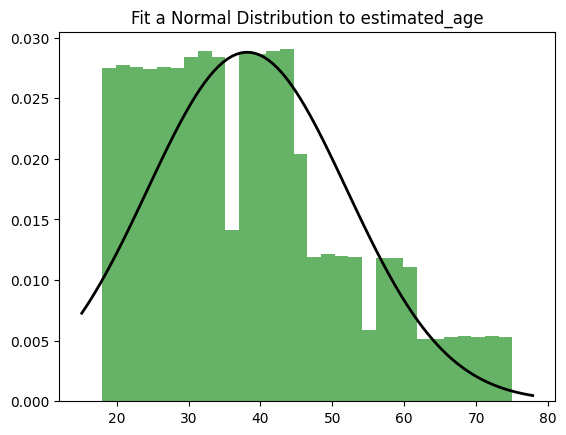

Mean: 38.1456, Standard Deviation: 13.855889264376598


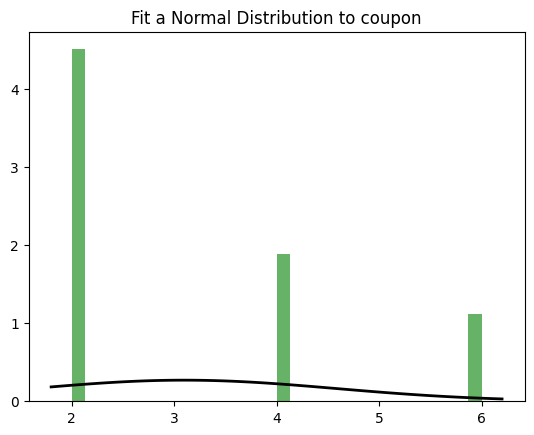

Mean: 3.09778, Standard Deviation: 1.477777296573021


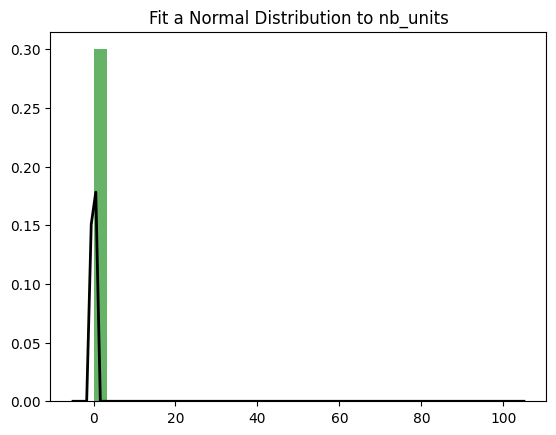

Mean: 0.01045, Standard Deviation: 0.2635288678051546


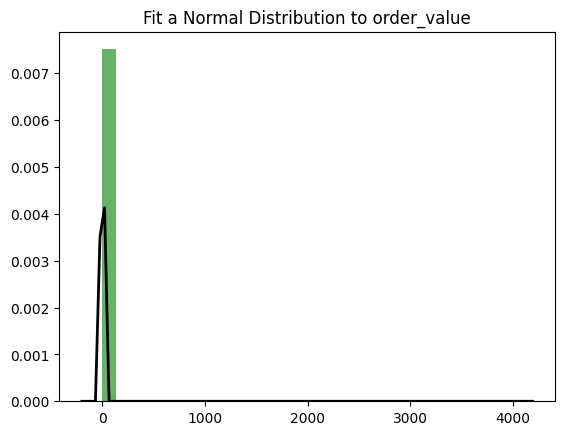

Mean: 0.38621333333333335, Standard Deviation: 10.305903126905259


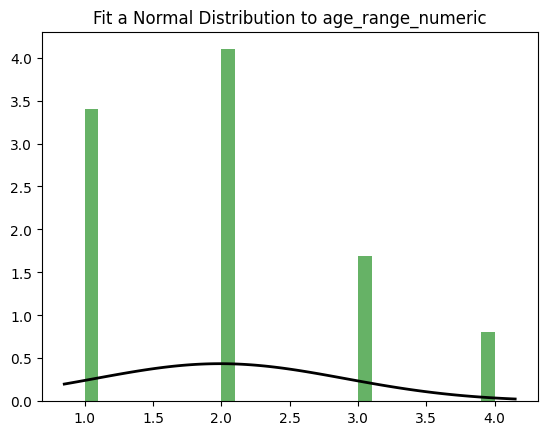

Mean: 1.9899533333333332, Standard Deviation: 0.9117194732055591


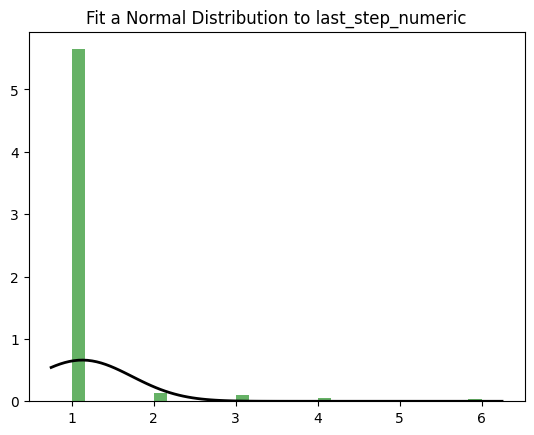

Mean: 1.1293966666666666, Standard Deviation: 0.6040031754791434


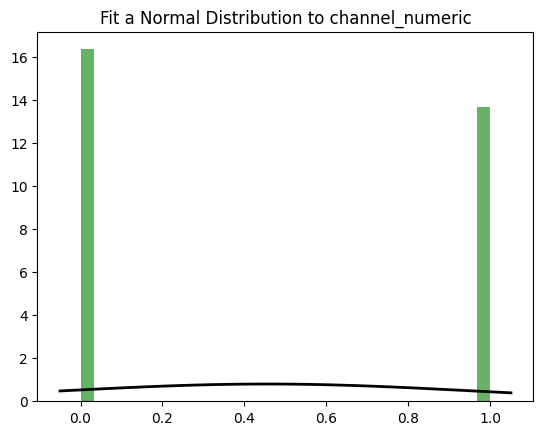

Mean: 0.45496333333333333, Standard Deviation: 0.4979675678752137


In [82]:
for col in analytic_df.columns:
    if col != 'id':
        try:
            # Assuming 'mkt_data' is your DataFrame, and 'col' is the numeric column you're interested in
            column_data = analytic_df[col]  # Replace 'column_name' with your actual column name

            # Fit a normal distribution to the column data
            params = stats.norm.fit(column_data)

            # Plot the histogram of the data and the fitted normal distribution
            plt.hist(column_data, bins=30, density=True, alpha=0.6, color='g')

            # Plot the fitted normal distribution
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = stats.norm.pdf(x, *params)
            plt.plot(x, p, 'k', linewidth=2)
            plt.title(f'Fit a Normal Distribution to {col}')
            plt.show()

            # You can also print the estimated parameters (mean and std deviation)
            print(f"Mean: {params[0]}, Standard Deviation: {params[1]}")
        except:
            continue

## Frequency tables

In [53]:
for col in mkt_data.columns:
    if col != 'send_date' and mkt_data[col].dtype != 'int64':
        print(f"Counts for column {col}:")
        print(mkt_data.groupby(col).size())
        print('\n')

Counts for column age_range:
age_range
18-30    102107
31-45    122900
46-60     50893
60+       24100
dtype: int64


Counts for column channel:
channel
Email    136489
SMS      163511
dtype: int64


Counts for column last_step:
last_step
added to cart      2753
bounced            6950
payment page        949
purchased          1862
received         282234
saw review         5252
dtype: int64




## Histograms

Could not plot histogram for column send_date: no numeric data to plot


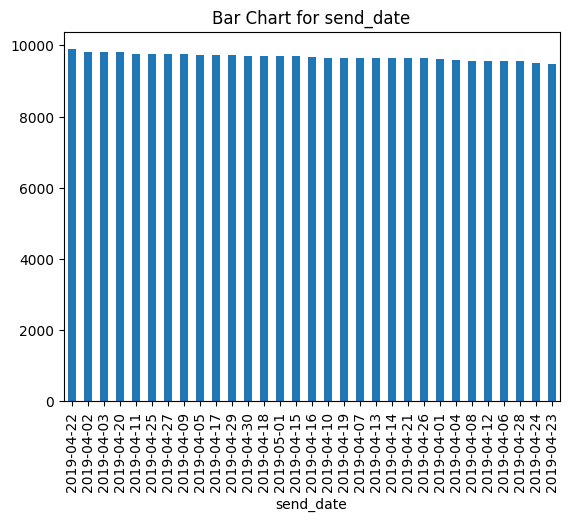

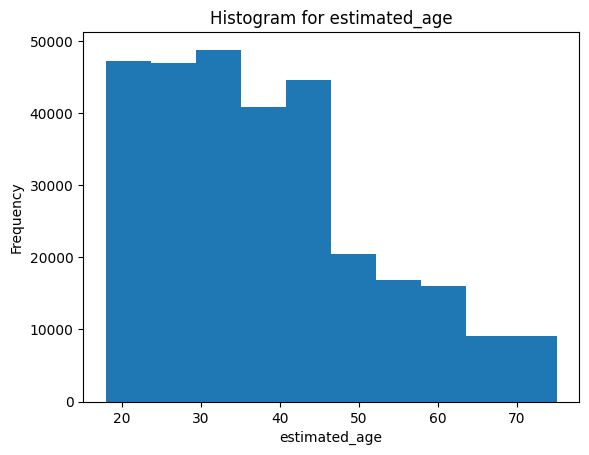

Could not plot histogram for column age_range: no numeric data to plot


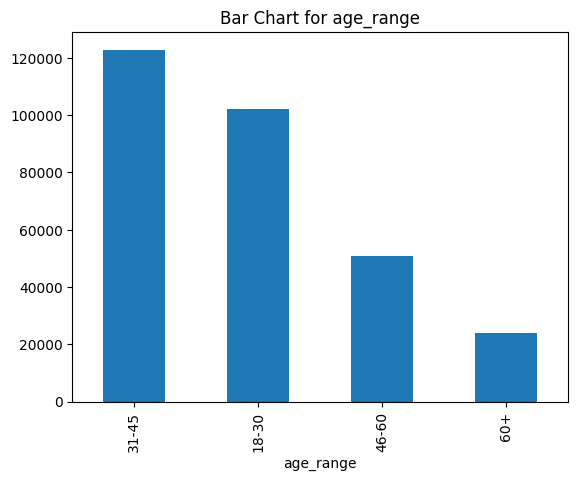

Could not plot histogram for column channel: no numeric data to plot


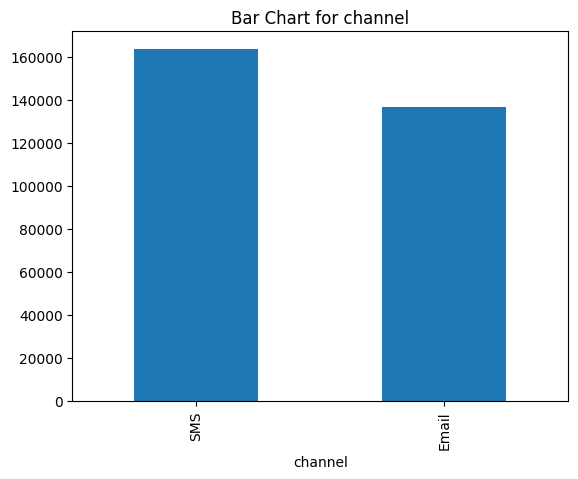

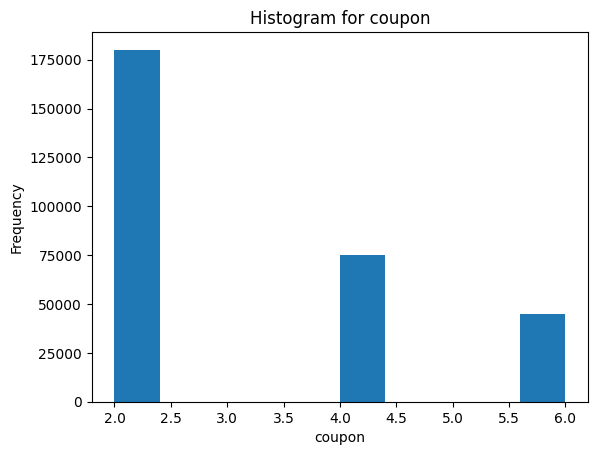

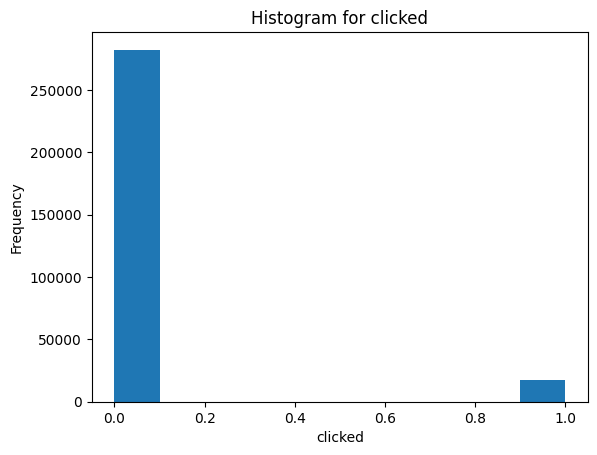

Could not plot histogram for column last_step: no numeric data to plot


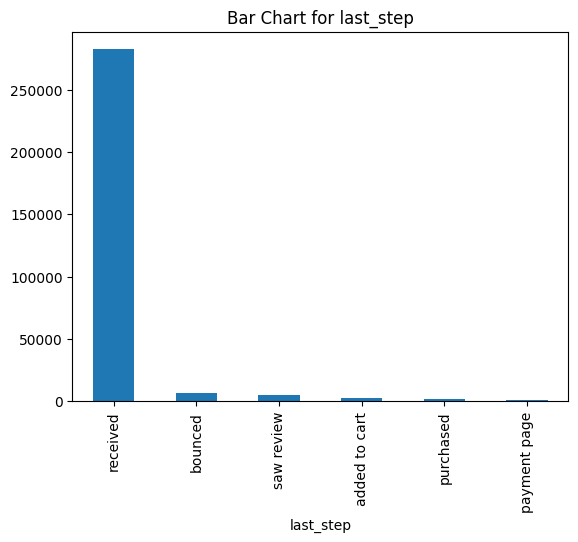

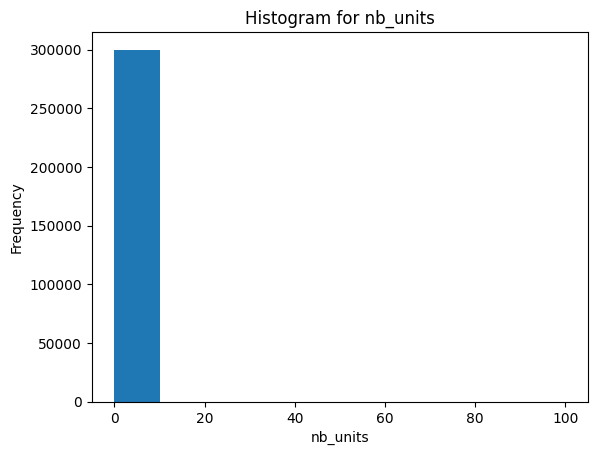

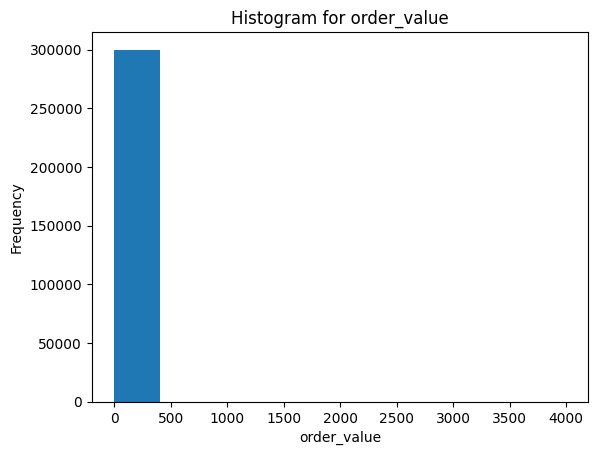

In [54]:
for col in mkt_data.columns:
    if col == 'id':
        continue

    # Flag to check if histogram is plotted
    histogram_plotted = False
    
    # Try plotting a histogram for numeric columns
    try:
        mkt_data[col].plot(kind='hist', title=f'Histogram for {col}')
        plt.xlabel(col)
        plt.show()
        histogram_plotted = True  # Set flag if histogram is plotted
    except Exception as e:
        print(f"Could not plot histogram for column {col}: {e}")

    # Only try plotting bar chart if histogram was not plotted
    if not histogram_plotted:
        try:
            mkt_data[col].value_counts().plot(kind='bar', title=f'Bar Chart for {col}')
            plt.xlabel(col)
            plt.show()
        except Exception as e:
            print(f"Could not plot bar chart for column {col}: {e}")

## Bivariate plots

In [55]:
mkt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             300000 non-null  int64 
 1   send_date      300000 non-null  object
 2   estimated_age  300000 non-null  int64 
 3   age_range      300000 non-null  object
 4   channel        300000 non-null  object
 5   coupon         300000 non-null  int64 
 6   clicked        300000 non-null  int64 
 7   last_step      300000 non-null  object
 8   nb_units       300000 non-null  int64 
 9   order_value    300000 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.9+ MB


In [72]:
analytic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   estimated_age      300000 non-null  int64
 1   coupon             300000 non-null  int64
 2   nb_units           300000 non-null  int64
 3   order_value        300000 non-null  int64
 4   age_range_numeric  300000 non-null  int64
 5   last_step_numeric  300000 non-null  int64
 6   channel_numeric    300000 non-null  int64
dtypes: int64(7)
memory usage: 16.0 MB


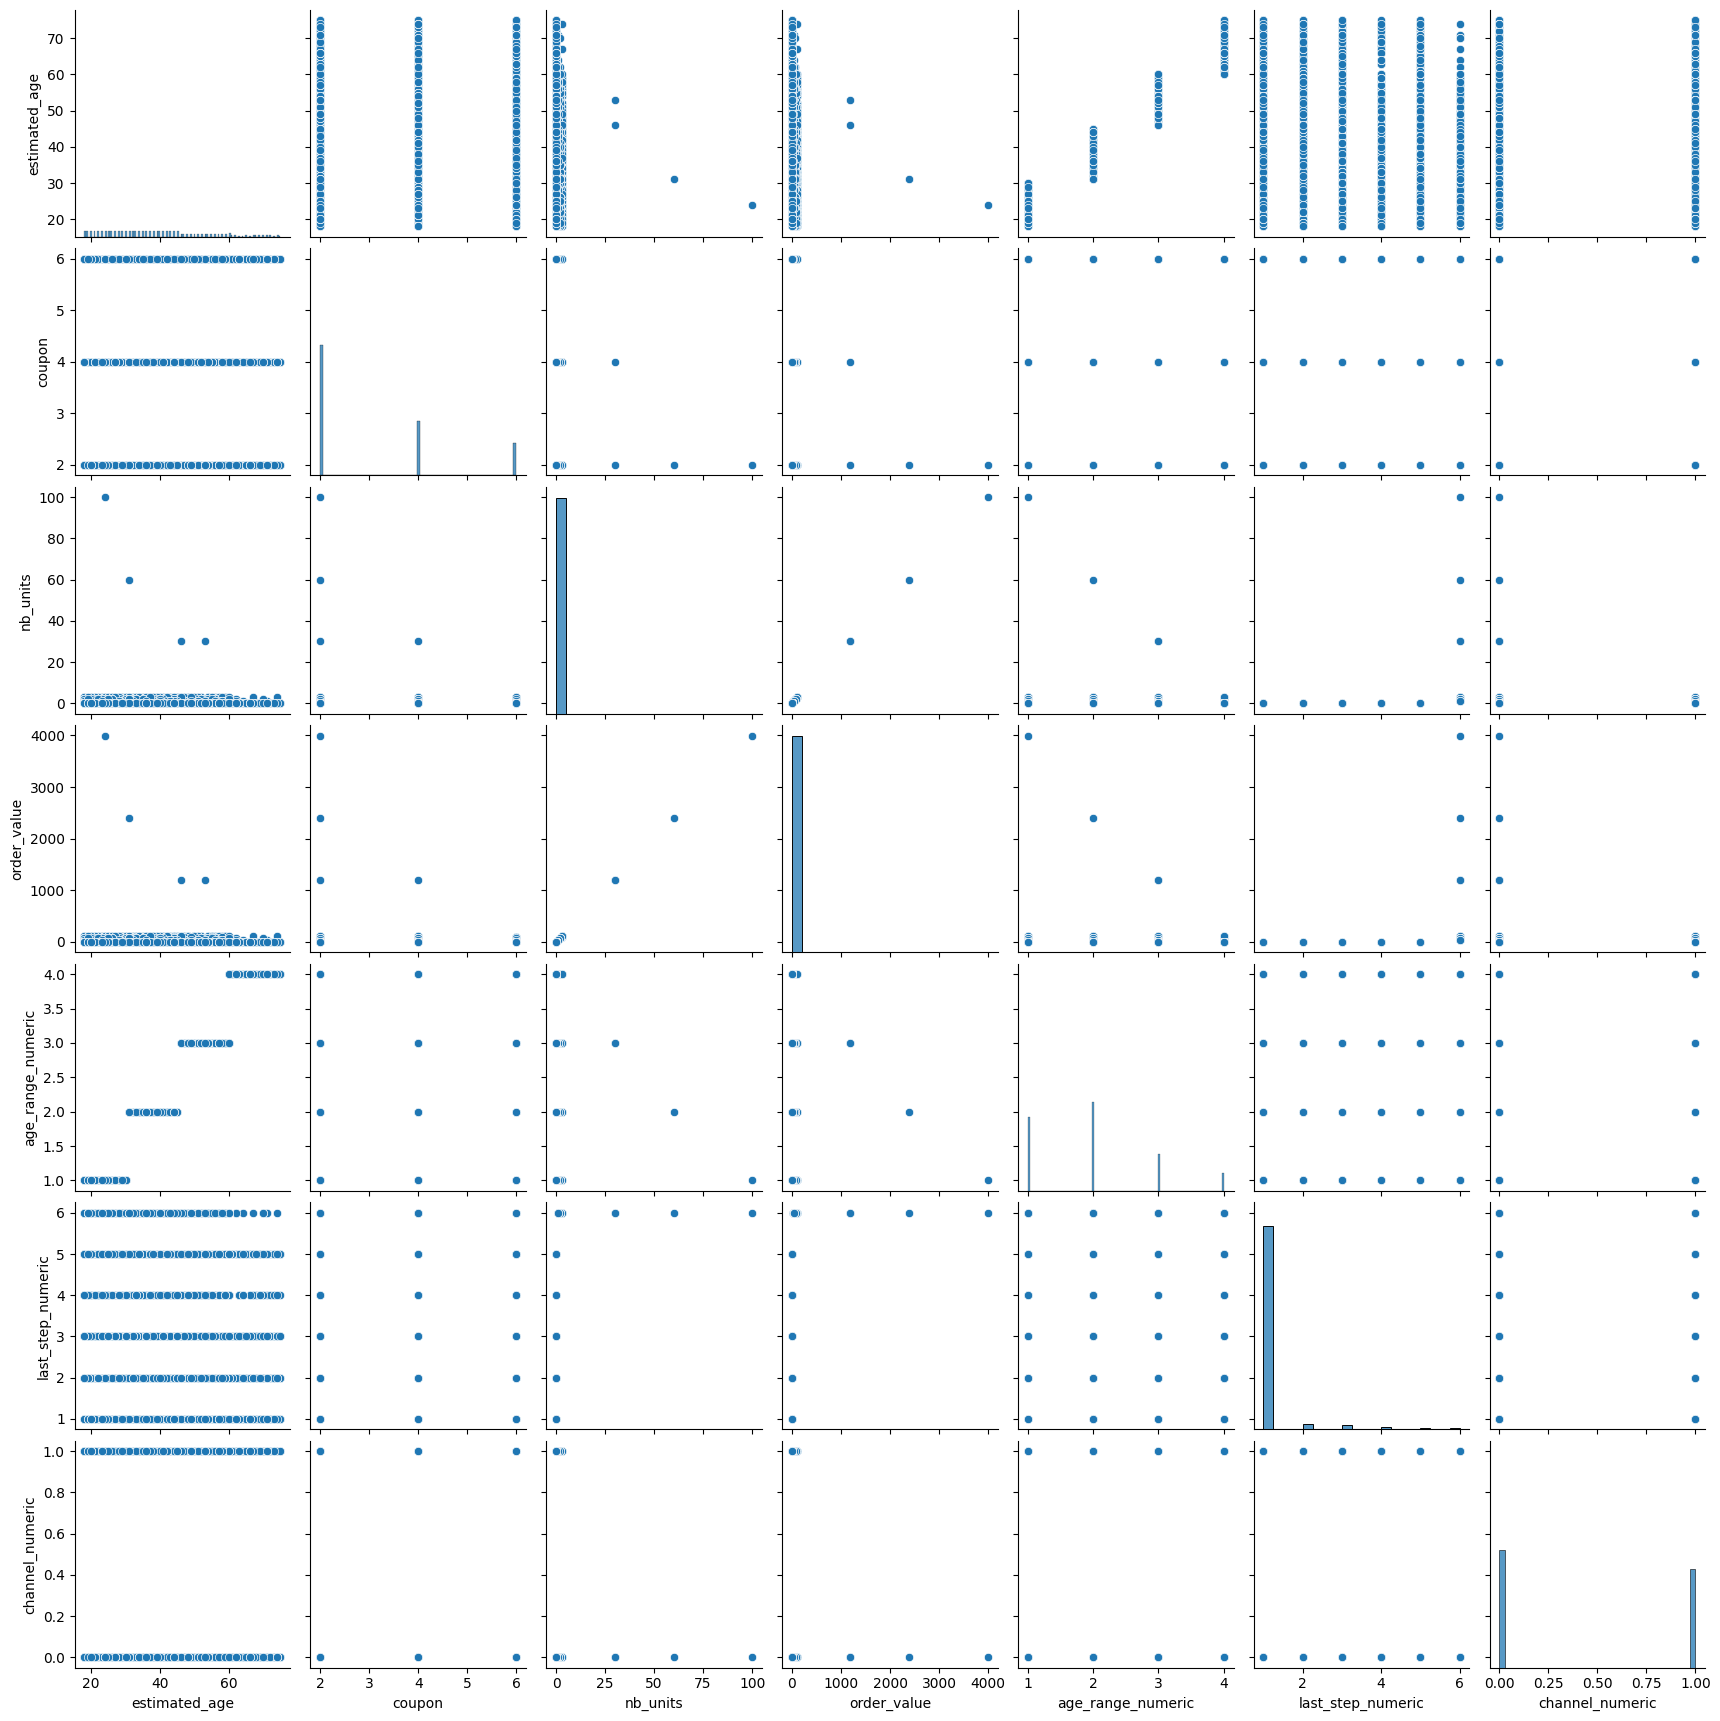

In [73]:
sns.pairplot(analytic_df)
plt.show()

## Correlation table

In [74]:
# Compute the correlation matrix
correlation_matrix = analytic_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                   estimated_age    coupon  nb_units  order_value  \
estimated_age           1.000000  0.000914 -0.006423    -0.006197   
coupon                  0.000914  1.000000  0.002520     0.000746   
nb_units               -0.006423  0.002520  1.000000     0.999161   
order_value            -0.006197  0.000746  0.999161     1.000000   
age_range_numeric       0.953711  0.000803 -0.006070    -0.005844   
last_step_numeric      -0.023247  0.021590  0.319766     0.302193   
channel_numeric        -0.001521  0.001473  0.001186     0.001046   

                   age_range_numeric  last_step_numeric  channel_numeric  
estimated_age               0.953711          -0.023247        -0.001521  
coupon                      0.000803           0.021590         0.001473  
nb_units                   -0.006070           0.319766         0.001186  
order_value                -0.005844           0.302193         0.001046  
age_range_numeric           1.000000          -0.024485        -0.002876

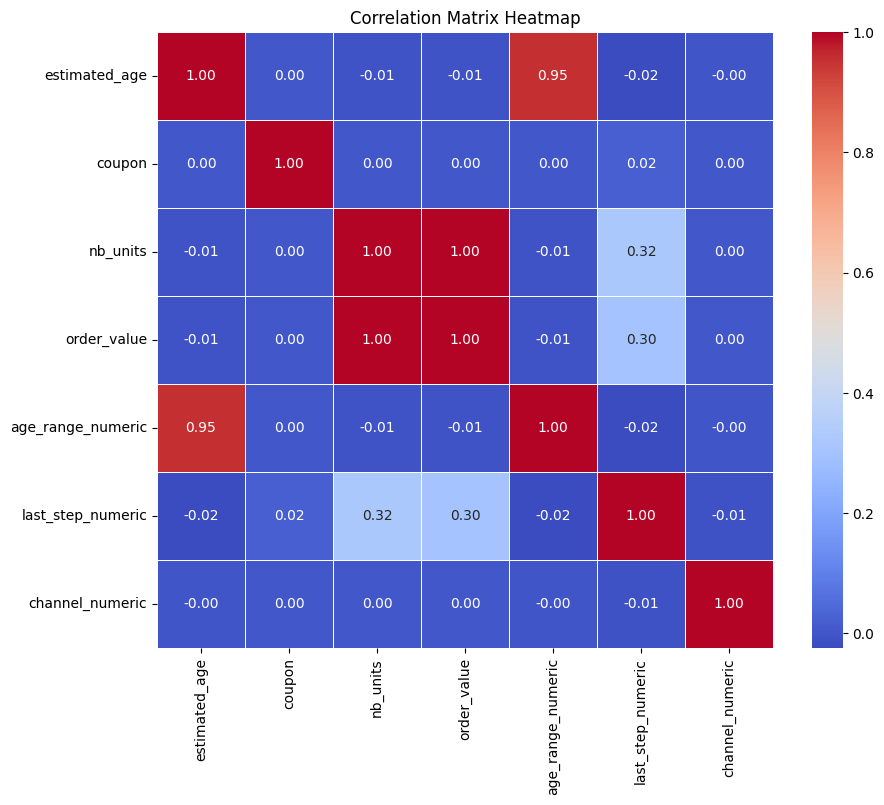

In [75]:
# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)

# Add a title and display the plot
plt.title('Correlation Matrix Heatmap')
plt.show()

## A/B test among methods in each age group to select desirable method

In [ ]:
def get_statistics(df: pd.DataFrame, att: str) -> tuple:
    """
    Return mean, variance, and size (degree of freemdom + 1) for any attributes of one dataframe
    Input: dataframe name, attribute name
    Output: mu, var, n
    """
    mu = df[att].mean() # get mean
    var = df[att].var() # get variance
    n = df[att].size # get size, degree of freedom = size - 1
    return mu, var, n

def check_hypo_by_agerange(email_df: pd.DataFrame, sms_df: pd.DataFrame, att: str, agerange: str):
    """
    Verify Hypothesis that there is difference between email and 
    Input: dataframe for each method and tested attributes
    Output: hypo decision
    """
    email_mu, email_var, email_size = get_statistics(email_df[email_df['age_range'] == agerange], att)
    sms_mu, sms_var, sms_size = get_statistics(sms_df[sms_df['age_range'] == agerange], att)

    # Calculate std, z_score, p_value
    standard_error = math.sqrt((email_var / email_size) + (sms_var / sms_size))
    z_score = (email_mu - sms_mu) / standard_error
    print("Z-score:", z_score)
    p_value = norm.sf(abs(z_score))  # Multiply by 2 for a two-tailed test
    print('p-value:', p_value)
    if p_value < 0.05:
        print('Reject Null Hypothesis \n')
    else:
        print('Cannot reject Null Hypothesis \n')

In [ ]:
# Group by send_date and channel for rows where 'last_step' == 'purchased'
purchased_counts = mkt_data[mkt_data['last_step'] == 'purchased'].groupby(['send_date', 'channel']).size().rename('purchased_count')
total_counts = mkt_data.groupby(['age_range','send_date', 'channel']).size().rename('total_count')
combined_counts = purchased_counts.reset_index().merge(total_counts.reset_index(), on=['send_date', 'channel'], how='outer')
print(combined_counts)

combined_counts['purchased_percentage'] = combined_counts['purchased_count']/combined_counts['total_count'] * 100
combined_email_counts = combined_counts[combined_counts['channel'] == 'Email']
combined_sms_counts = combined_counts[combined_counts['channel'] == 'SMS']

      send_date channel  purchased_count age_range  total_count
0    2019-04-01   Email               34     18-30         1470
1    2019-04-01   Email               34     31-45         1853
2    2019-04-01   Email               34     46-60          799
3    2019-04-01   Email               34       60+          336
4    2019-04-01     SMS               21     18-30         1753
..          ...     ...              ...       ...          ...
243  2019-05-01   Email               34       60+          355
244  2019-05-01     SMS               29     18-30         1803
245  2019-05-01     SMS               29     31-45         2162
246  2019-05-01     SMS               29     46-60          896
247  2019-05-01     SMS               29       60+          414

[248 rows x 5 columns]


In [ ]:
for agerange in combined_counts['age_range'].unique():
    print(f'Investigating email vs sms for age range: {agerange}')
    check_hypo_by_agerange(email_df=combined_email_counts, 
                           sms_df=combined_sms_counts, 
                           att='purchased_percentage', 
                           agerange=agerange)

Investigating email vs sms for age range: 18-30
Z-score: 5.309229352498702
p-value: 5.504486408713201e-08
Reject Null Hypothesis 

Investigating email vs sms for age range: 31-45
Z-score: 5.844152961564428
p-value: 2.5457614027594263e-09
Reject Null Hypothesis 

Investigating email vs sms for age range: 46-60
Z-score: 5.782828650923549
p-value: 3.672743680476232e-09
Reject Null Hypothesis 

Investigating email vs sms for age range: 60+
Z-score: 5.654877289069287
p-value: 7.79788275716462e-09
Reject Null Hypothesis 



## A/B test among age group for each method

In [ ]:
def check_hypo_by_method(age1_df: pd.DataFrame, age2_df: pd.DataFrame, att: str, channel: str):
    """
    Verify Hypothesis that there is difference between email and 
    Input: dataframe for each method and tested attributes
    Output: hypo decision
    """
    mu1, var1, size1 = get_statistics(age1_df[age1_df['channel'] == channel], att)
    mu2, var2, size2 = get_statistics(age2_df[age2_df['channel'] == channel], att)

    # Calculate std, z_score, p_value
    standard_error = math.sqrt((var1 / size1) + (var2 / size2))
    z_score = (mu1 - mu2) / standard_error
    print("Z-score:", z_score)
    p_value = norm.sf(abs(z_score))  # Multiply by 2 for a two-tailed test
    print('p-value:', p_value)
    if p_value < 0.05:
        print('Reject Null Hypothesis \n')
    else:
        print('Cannot reject Null Hypothesis \n')

In [ ]:
combined_counts

,send_date,channel,purchased_count,age_range,total_count,purchased_percentage
0,2019-04-01,Email,34,18-30,1470,2.312925
1,2019-04-01,Email,34,31-45,1853,1.834862
2,2019-04-01,Email,34,46-60,799,4.255319
3,2019-04-01,Email,34,60+,336,10.119048
4,2019-04-01,SMS,21,18-30,1753,1.197946
...,...,...,...,...,...,...
243,2019-05-01,Email,34,60+,355,9.577465
244,2019-05-01,SMS,29,18-30,1803,1.608430
245,2019-05-01,SMS,29,31-45,2162,1.341351
246,2019-05-01,SMS,29,46-60,896,3.236607


In [ ]:
for agerange1, agerange2 in itertools.combinations(combined_counts['age_range'].unique(), 2):
    for channel in combined_counts['channel'].unique():
        print(f'Investigating {agerange1} vs {agerange2} for method: {channel}')
        df1 = combined_counts[combined_counts['age_range'] == agerange1]
        df2 = combined_counts[combined_counts['age_range'] == agerange2]
        check_hypo_by_method(age1_df=df1, 
                            age2_df=df2, 
                            att='purchased_percentage', 
                            channel=channel)

Investigating 18-30 vs 31-45 for method: Email
Z-score: 4.71973638937039
p-value: 1.180752366548354e-06
Reject Null Hypothesis 

Investigating 18-30 vs 31-45 for method: SMS
Z-score: 4.905301302898469
p-value: 4.6642015464309933e-07
Reject Null Hypothesis 

Investigating 18-30 vs 46-60 for method: Email
Z-score: -16.56808662842089
p-value: 5.926899614251251e-62
Reject Null Hypothesis 

Investigating 18-30 vs 46-60 for method: SMS
Z-score: -15.839098718564708
p-value: 8.360005780017339e-57
Reject Null Hypothesis 

Investigating 18-30 vs 60+ for method: Email
Z-score: -27.89479853858131
p-value: 1.5426447746282987e-171
Reject Null Hypothesis 

Investigating 18-30 vs 60+ for method: SMS
Z-score: -26.41584213087034
p-value: 4.506028431595518e-154
Reject Null Hypothesis 

Investigating 31-45 vs 46-60 for method: Email
Z-score: -20.051952297311033
p-value: 9.70388250718964e-90
Reject Null Hypothesis 

Investigating 31-45 vs 46-60 for method: SMS
Z-score: -19.324878981628473
p-value: 1.658804